# Recommender with splitted user 

In [3]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('..')

dataset = pd.read_csv('data_train.csv')
dataset

,row,col,data
0,0,10080,1.0
1,0,19467,1.0
2,1,2665,1.0
3,1,7494,1.0
4,1,17068,1.0
...,...,...,...
113263,7945,2476,1.0
113264,7945,12319,1.0
113265,7945,21384,1.0
113266,7946,8699,1.0


In [4]:
users = dataset.row
items = dataset.col
data = dataset.data
URM_all = sps.coo_matrix((data, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(7947, 25975)

In [5]:
items_per_user = np.ediff1d(URM_all.indptr) #tells in which position each of the rows begin
users_per_item = np.ediff1d(sps.csc_matrix(URM_all).indptr)
URM_all = sps.csr_matrix(URM_all)

In [6]:
items_per_user = np.sort(items_per_user) #sorting based on the single value. Losing reference to the user. 
users_per_item = np.sort(users_per_item)

In [7]:
ICM_df = pd.read_csv('data_ICM_title_abstract.csv')
ICM_df

,row,col,data
0,0,1185,1.015524
1,0,2507,0.459024
2,0,3534,0.227742
3,0,8766,0.501549
4,0,10862,0.297011
...,...,...,...
490686,25974,12554,0.963016
490687,25974,13003,0.104613
490688,25974,16236,0.118760
490689,25974,18797,0.363301


In [8]:
items = ICM_df.row
features = ICM_df.col
data = ICM_df.data
ICM_all = sps.coo_matrix((data, (items, features)))
ICM_all = ICM_all.tocsr() #fast row access -> fast access to users 
ICM_all.shape

(25975, 20000)

In [9]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [10]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

# Data pre-processing

In [11]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)

In [12]:
from GraphBased.P3alphaRecommender import P3alphaRecommender
from GraphBased.RP3betaRecommender import RP3betaRecommender
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender

recommender_alpha = P3alphaRecommender(URM_train)
recommender_alpha.fit(topK=170, alpha = 0.45, implicit = True)

recommender_beta_ICM = RP3betaRecommender(ICM_all.T)
recommender_beta_ICM.fit(topK=70, alpha=0.2, beta=0.5, implicit=False)
recommender_beta_ICM.URM_train = URM_train

hybridrecommender = ItemKNNSimilarityHybridRecommender(URM_train, recommender_alpha.W_sparse, recommender_beta_ICM.W_sparse)
hybridrecommender.fit(topK=200, alpha = 0.1)

P3alphaRecommender: URM Detected 45 (0.57 %) cold users.
P3alphaRecommender: URM Detected 2011 (7.74 %) cold items.
RP3betaRecommender: URM Detected 2 (0.01 %) cold users.
RP3betaRecommender: URM Detected 25 (0.10 %) cold items.
ItemKNNSimilarityHybridRecommender: URM Detected 45 (0.57 %) cold users.
ItemKNNSimilarityHybridRecommender: URM Detected 2011 (7.74 %) cold items.


In [13]:
from KNN.UserKNNCFRecommender import UserKNNCFRecommender

recommender_cold = UserKNNCFRecommender(URM_train)
recommender_cold.fit(shrink=100, topK=150, feature_weighting = "TF-IDF")

UserKNNCFRecommender: URM Detected 45 (0.57 %) cold users.
UserKNNCFRecommender: URM Detected 2011 (7.74 %) cold items.
Similarity column 7947 ( 100 % ), 15909.24 column/sec, elapsed time 0.01 min


In [14]:
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

recommender_item_cf = ItemKNNCFRecommender(URM_train)
recommender_item_cf.fit(shrink=600, topK=550, feature_weighting = "TF-IDF")

ItemKNNCFRecommender: URM Detected 45 (0.57 %) cold users.
ItemKNNCFRecommender: URM Detected 2011 (7.74 %) cold items.
Similarity column 25975 ( 100 % ), 6037.62 column/sec, elapsed time 0.07 min


In [15]:
recommeder_KNNItemCBF = ItemKNNCBFRecommender(URM_train, ICM_all)
recommeder_KNNItemCBF.fit(topK=100, shrink=400, feature_weighting = 'TF-IDF')

ItemKNNCBFRecommender: URM Detected 45 (0.57 %) cold users.
ItemKNNCBFRecommender: URM Detected 2011 (7.74 %) cold items.
Similarity column 25975 ( 100 % ), 3976.89 column/sec, elapsed time 0.11 min


In [16]:
from Base.NonPersonalizedRecommender import TopPop

recommender_top_popular = TopPop(URM_train)
recommender_top_popular.fit()

TopPopRecommender: URM Detected 45 (0.57 %) cold users.
TopPopRecommender: URM Detected 2011 (7.74 %) cold items.


In [17]:
# userei un CF per warm 
# CBF per i cold 

In [18]:
grouped_users = dataset.groupby(['row']).count()
grouped_users

,col,data
row,,
0,2,2
1,6,6
2,2,2
3,2,2
4,7,7
...,...,...
7942,5,5
7943,3,3
7944,156,156


In [22]:
sorted_users = grouped_users.sort_values(by=['col'], ascending=True)
sorted_users = sorted_users.index.to_numpy()
sorted_users

array([6012, 3608, 3171, ..., 1863, 2282, 7382])

In [24]:
block_size = int(len(sorted_users)*0.05)
block_size

397

In [26]:

MAP_p3aplha_rp3beta_per_group = []
MAP_user_cf_cold_per_group = []
MAP_item_cf_cold_per_group = []
MAP_item_cbf_per_group = []
MAP_top_pop_per_group = []
cutoff = 10

'''
users_not_in_group = grouped_users.copy()
users_not_in_group = users_not_in_group.loc[users_not_in_group.col >= 3]
users_not_in_group = users_not_in_group.reset_index()['row']
'''

for group_id in range(0, 10):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(sorted_users))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert = True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_p3_rp3 = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users = users_not_in_group)
    
    results, _ = evaluator_p3_rp3.evaluateRecommender(hybridrecommender)
    MAP_p3aplha_rp3beta_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_cold)
    MAP_user_cf_cold_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_item_cf)
    MAP_item_cf_cold_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_p3_rp3.evaluateRecommender(recommeder_KNNItemCBF)
    MAP_item_cbf_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_top_popular)
    MAP_top_pop_per_group.append(results[cutoff]["MAP"])

EvaluatorHoldout: Ignoring 7550 Users
EvaluatorHoldout: Processed 98 ( 100.00% ) in 0.08 sec. Users per second: 1159
EvaluatorHoldout: Processed 98 ( 100.00% ) in 0.05 sec. Users per second: 1886
EvaluatorHoldout: Processed 98 ( 100.00% ) in 0.05 sec. Users per second: 1899
EvaluatorHoldout: Processed 98 ( 100.00% ) in 0.05 sec. Users per second: 1870
EvaluatorHoldout: Processed 98 ( 100.00% ) in 0.08 sec. Users per second: 1284
EvaluatorHoldout: Ignoring 7550 Users
EvaluatorHoldout: Processed 116 ( 100.00% ) in 0.09 sec. Users per second: 1342
EvaluatorHoldout: Processed 116 ( 100.00% ) in 0.06 sec. Users per second: 1966
EvaluatorHoldout: Processed 116 ( 100.00% ) in 0.06 sec. Users per second: 1923
EvaluatorHoldout: Processed 116 ( 100.00% ) in 0.06 sec. Users per second: 1998
EvaluatorHoldout: Processed 116 ( 100.00% ) in 0.08 sec. Users per second: 1541
EvaluatorHoldout: Ignoring 7550 Users
EvaluatorHoldout: Processed 144 ( 100.00% ) in 0.10 sec. Users per second: 1513
EvaluatorHo

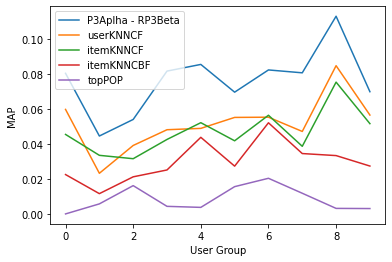

In [27]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(MAP_p3aplha_rp3beta_per_group, label="P3Aplha - RP3Beta")
pyplot.plot(MAP_user_cf_cold_per_group, label="userKNNCF")
pyplot.plot(MAP_item_cf_cold_per_group, label="itemKNNCF")
pyplot.plot(MAP_item_cbf_per_group, label="itemKNNCBF")
pyplot.plot(MAP_top_pop_per_group, label="topPOP")
pyplot.ylabel('MAP')
pyplot.xlabel('User Group')
pyplot.legend()
pyplot.show()